In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,recall_score,precision_score,f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from jupyterthemes import jtplot
jtplot.style()

%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 400

# Metric Functions

In [14]:
def run_baseline(mdl, 
                 X_train, y_train, X_test, y_test,
                 verbose=True):
    """Return a dict of model performance indicators."""
    
    results = {}
    
    # 1. Fit the model on the training set
    mdl.fit(X_train, y_train)

    # 2. Predict on the training and test sets
    y_pred_train = mdl.predict(X_train)
    y_pred_test = mdl.predict(X_test)
    pred_proba = mdl.predict_proba(X_test)[:,1]
    
    # 3. Train & test accuracy
    results['train_accuracy'] = accuracy_score(y_train, y_pred_train)
    results['test_accuracy'] = accuracy_score(y_test, y_pred_test)
    results['ROC_AUC'] = roc_auc_score(y_test, pred_proba)
    
    if verbose:
        print('Train Accuracy: ', results['train_accuracy'])
        print('Test Accuracy: ', results['test_accuracy'])
        print('\nOrder of classes: ', mdl.classes_)
    
    
    # 4. Test confusion matrix
    confusion_df = pd.DataFrame(\
                        data=confusion_matrix(y_test, y_pred_test),
                        index=[f'actual {target_class}' for target_class in mdl.classes_],
                        columns=[f'predicted {target_class}' for target_class in mdl.classes_])

    if verbose:
        print('\nTest Confusion Matrix: \n', confusion_df)
        print(classification_report(y_test, y_pred_test))
    
    # 5. Test recall and precision (if no samples, set recall/precision to 0)
    
    results['test_recall'] = recall_score(y_test, y_pred_test, 
                                          pos_label=1, zero_division=0)
    
    results['test_precision'] = precision_score(y_test, y_pred_test, 
                                                pos_label=1, zero_division=0)
    results['F1'] = f1_score(y_test,y_pred_test,
                             pos_label=1, zero_division=0)
        
    return results
    
    
def test_models(models, X_train, y_train, X_test, y_test,
                verbose=False):
    """Returns DataFrame of baseline results 
       given a dict `models` of names/sklearn models."""
    results = {}
    
    # Fit each model and store how it performs on the test set
    for name,model in models.items():
        if verbose:
            print('\nRunning {} - {}'.format(name, model))
        
        results[name] = run_baseline(model, 
                                     X_train, y_train, 
                                     X_test, y_test, 
                                     verbose=False)
        if verbose:
            print('Results: ', results[name])

    return pd.DataFrame.from_dict(results, orient='index').sort_index()

def metrics(y_test, y_predict, pred_proba):
    print('Accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['Predicted Down', 'Predicted Up/Unch'], 
                            columns=['Actual Down', 'Actual Up/Unch']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')
    print('ROC_AUC SCORE %s ' %roc_auc_score(y_test, pred_proba))
    

# Data 

In [3]:
# Bring in data
path = '../thecap/Data/polyfeatures.csv'
df = pd.read_csv(path, index_col='Date', parse_dates=True)
df.head(2) 

,Target_1d,vol%_chg1d,vol%_chg3d,vol%_chg8d,range,range%,JPY%,Close_JPY,btc_tweets,btc_activeaddresses,btc_mining_profitability,btc_transactionfees,btc_median_transaction_fee,btc_mediantransactionvalue,sub_growth_%chg,btc_gtrends,buybitcoin_gtrends,ETH_gtrends,crypto_gtrends,vol%_chg1d^2,vol%_chg1d vol%_chg3d,vol%_chg1d vol%_chg8d,vol%_chg1d range,vol%_chg1d range%,vol%_chg1d JPY%,vol%_chg1d Close_JPY,vol%_chg1d btc_tweets,vol%_chg1d btc_activeaddresses,vol%_chg1d btc_mining_profitability,vol%_chg1d btc_transactionfees,vol%_chg1d btc_median_transaction_fee,vol%_chg1d btc_mediantransactionvalue,vol%_chg1d sub_growth_%chg,vol%_chg1d btc_gtrends,vol%_chg1d buybitcoin_gtrends,vol%_chg1d ETH_gtrends,vol%_chg1d crypto_gtrends,vol%_chg3d^2,vol%_chg3d vol%_chg8d,vol%_chg3d range,vol%_chg3d range%,vol%_chg3d JPY%,vol%_chg3d Close_JPY,vol%_chg3d btc_tweets,vol%_chg3d btc_activeaddresses,vol%_chg3d btc_mining_profitability,vol%_chg3d btc_transactionfees,vol%_chg3d btc_median_transaction_fee,vol%_chg3d btc_mediantransactionvalue,vol%_chg3d sub_growth_%chg,...,btc_activeaddresses sub_growth_%chg,btc_activeaddresses btc_gtrends,btc_activeaddresses buybitcoin_gtrends,btc_activeaddresses ETH_gtrends,btc_activeaddresses crypto_gtrends,btc_mining_profitability^2,btc_mining_profitability btc_transactionfees,btc_mining_profitability btc_median_transaction_fee,btc_mining_profitability btc_mediantransactionvalue,btc_mining_profitability sub_growth_%chg,btc_mining_profitability btc_gtrends,btc_mining_profitability buybitcoin_gtrends,btc_mining_profitability ETH_gtrends,btc_mining_profitability crypto_gtrends,btc_transactionfees^2,btc_transactionfees btc_median_transaction_fee,btc_transactionfees btc_mediantransactionvalue,btc_transactionfees sub_growth_%chg,btc_transactionfees btc_gtrends,btc_transactionfees buybitcoin_gtrends,btc_transactionfees ETH_gtrends,btc_transactionfees crypto_gtrends,btc_median_transaction_fee^2,btc_median_transaction_fee btc_mediantransactionvalue,btc_median_transaction_fee sub_growth_%chg,btc_median_transaction_fee btc_gtrends,btc_median_transaction_fee buybitcoin_gtrends,btc_median_transaction_fee ETH_gtrends,btc_median_transaction_fee crypto_gtrends,btc_mediantransactionvalue^2,btc_mediantransactionvalue sub_growth_%chg,btc_mediantransactionvalue btc_gtrends,btc_mediantransactionvalue buybitcoin_gtrends,btc_mediantransactionvalue ETH_gtrends,btc_mediantransactionvalue crypto_gtrends,sub_growth_%chg^2,sub_growth_%chg btc_gtrends,sub_growth_%chg buybitcoin_gtrends,sub_growth_%chg ETH_gtrends,sub_growth_%chg crypto_gtrends,btc_gtrends^2,btc_gtrends buybitcoin_gtrends,btc_gtrends ETH_gtrends,btc_gtrends crypto_gtrends,buybitcoin_gtrends^2,buybitcoin_gtrends ETH_gtrends,buybitcoin_gtrends crypto_gtrends,ETH_gtrends^2,ETH_gtrends crypto_gtrends,crypto_gtrends^2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31,0.0,0.160589,-0.227634,0.517258,1.163969,0.065188,0.000923,112.769997,64989.0,847972.0,2.281,25.170,15.291,2182.0,0.007039,48.214286,0.0,1.295976,6.291338,0.025789,-0.036555,0.083066,0.18692,0.010468,0.000148,18.10958,10436.494994,136174.668533,0.366303,4.042016,2.455561,350.404408,0.001130,7.742666,0.0,0.208119,1.010317,0.051817,-0.117746,-0.264959,-0.014839,-0.00021,-25.670286,-14793.706235,-193027.260974,-0.519233,-5.729548,-3.480752,-496.697395,-0.001602,...,5968.591707,4.088436e+07,0.0,1.098951e+06,5.334878e+06,5.202961,57.412770,34.878771,4977.142,0.016055,109.976786,0.0,2.956122,14.350541,633.528900,384.87447,54920.940,0.177163,1213.553571,0.0,32.619719,158.352968,233.814681,33364.962,0.107628,737.244643,0.0,19.816771,96.200844,4761124.0,15.358369,105203.571429,0.0,2827.819880,13727.698692,0.000050,0.339364,0.0,0.009122,0.044283,2324.617347,0.0,62.484563,303.332350,0.0,0.0,0.0,1.679554,8.153423,39.580929
2018-01-01,0.0,0.160589,-0.227634,0.517258,1.163969,0.065188,0.000923,112.769997,62044.0,842391.0,2.174,26.274,14.625,2104.0,0.007324,46.428571,0

# Train Test Split


In [4]:
X = df._get_numeric_data().drop(columns=['Target_1d'])
y = df['Target_1d']
features = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    stratify = y,
                                                    random_state = 42)

# Null Model

In [347]:
dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train, y_train)

y_pred_train = dc.predict(X_train)
y_pred_test = dc.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_train, y_pred_train))
print('Test Accuracy: ', accuracy_score(y_test, y_pred_test))

Train Accuracy:  0.5214050493962679
Test Accuracy:  0.5217391304347826


# SVM Pipeline

In [16]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('SVC', SVC(probability=True,random_state=42))
    ])

params = {'pca__n_components': [3, 10, 15, 20, 30, 50],
          'SVC__gamma': [1e-5, 1e-4, 1e-3, 1e-2],
          'SVC__C' : [1e-5, 1e-3, 1e-2, 1e-1],
          'SVC__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'SVC__class_weight' : ['balanced', None],
          'SVC__shrinking' : [True, False]
          }

cv_folds = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

gs = GridSearchCV(pipe, params, cv=cv_folds,n_splits=10, scoring='accuracy')

# Fit
gs.fit(X_train, y_train)

preds = gs.predict(X_test)

pred_proba = gs.predict_proba(X_test)[:,1]

In [17]:
#Base Line
y_test.value_counts(normalize=True)

1.0    0.521739
0.0    0.478261
Name: Target_1d, dtype: float64

In [19]:
gs.best_score_

0.5543541196224885

In [20]:
gs.score(X_train,y_train) , gs.score(X_test,y_test)

(0.7233809001097695, 0.4906832298136646)

In [21]:
metrics(y_test, preds, pred_proba)

Accuracy score 0.4906832298136646  

----------------------------------------------------------------
                   Actual Down  Actual Up/Unch
Predicted Down              25              52
Predicted Up/Unch           30              54 

-----------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.45      0.32      0.38        77
         1.0       0.51      0.64      0.57        84

    accuracy                           0.49       161
   macro avg       0.48      0.48      0.47       161
weighted avg       0.48      0.49      0.48       161

-----------------------------------------------------------------
ROC_AUC SCORE 0.4817563388991961 


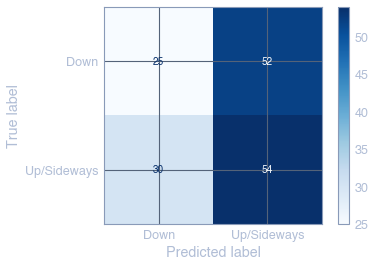

In [22]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Down', 'Up/Sideways']);

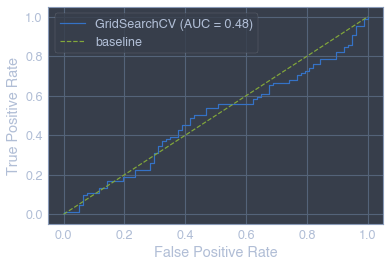

In [23]:
plot_roc_curve(gs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

# XGB Pipeline

In [26]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [89]:
pipe2 = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('XGB', XGBClassifier(seed=21,tree_method = "exact",eval_metric = ["auc",'error','map'], 
                          objective = "binary:logistic"))])

params2 = { 'pca__n_components': [5, 10, 15, 35, 80, 100],
            "XGB__learning_rate": [0.3, 0.1, 0.05, 0.01, 0.0033, 0.0011, 0.001],
            "XGB__gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
            "XGB__max_depth": [2, 4, 8, 10],
            "XGB__colsample_bytree": [0.2, 0.6, 0.8, 1.0],
            "XGB__subsample": [0.3, 0.4, 0.5, 0.6, 0.7],
            "XGB__reg_alpha": [0.1, 0.3, 0.5, 1],
            "XGB__reg_lambda": [1, 1.5, 2, 3, 4.5],
            "XGB__min_child_weight": [1, 2, 4, 8, 10 ,15],
            "XGB__n_estimators": [100, 250, 500, 1000]}

cv_folds2 = StratifiedKFold(n_splits=8,shuffle=True,random_state=42)

# Create RandomizedSearchCV Object
rs = RandomizedSearchCV(pipe2, params2, n_iter=8, cv=cv_folds2, scoring='accuracy')

# Fit
rs.fit(X_train, y_train)

# predict
preds = rs.predict(X_test)

pred_proba = rs.predict_proba(X_test)[:,1]

In [90]:
#Base Line
y_test.value_counts(normalize=True)

1.0    0.521739
0.0    0.478261
Name: Target_1d, dtype: float64

In [91]:
rs.best_params_

{'pca__n_components': 89,
 'XGB__subsample': 0.3,
 'XGB__reg_lambda': 3,
 'XGB__reg_alpha': 1,
 'XGB__n_estimators': 1000,
 'XGB__min_child_weight': 1,
 'XGB__max_depth': 13,
 'XGB__learning_rate': 0.0011,
 'XGB__gamma': 0.5,
 'XGB__colsample_bytree': 0.3}

In [92]:
rs.best_score_

0.5488210005211047

In [93]:
rs.score(X_train,y_train) , rs.score(X_test,y_test)

(0.9506037321624589, 0.4968944099378882)

In [94]:
metrics(y_test, preds, pred_proba)

Accuracy score 0.4968944099378882  

----------------------------------------------------------------
                   Actual Down  Actual Up/Unch
Predicted Down              30              47
Predicted Up/Unch           34              50 

-----------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.47      0.39      0.43        77
         1.0       0.52      0.60      0.55        84

    accuracy                           0.50       161
   macro avg       0.49      0.49      0.49       161
weighted avg       0.49      0.50      0.49       161

-----------------------------------------------------------------
ROC_AUC SCORE 0.5003092145949288 


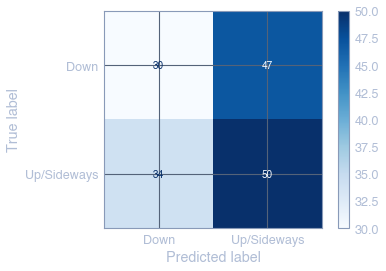

In [95]:
plot_confusion_matrix(rs, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Down', 'Up/Sideways']);

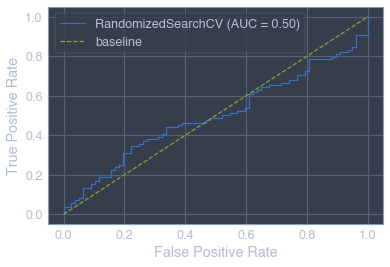

In [96]:
plot_roc_curve(rs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [108]:
pipe3 = Pipeline([
    ('ss', StandardScaler()),
    ('XGB', XGBClassifier(seed=42,tree_method = "exact",eval_metric = ["auc",'error','map'], 
                          objective = "binary:logistic"))])

params3 = { 
            "XGB__learning_rate": [0.3, 0.1, 0.05, 0.01, 0.0033, 0.0011, 0.001],
            "XGB__gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
            "XGB__max_depth": [3, 6, 8, 10, 20],
            "XGB__colsample_bytree": [0.2, 0.4, 0.8, 1.0],
            "XGB__subsample": [0.3, 0.4, 0.5, 0.6, 0.7],
            "XGB__reg_alpha": [0.1, 0.3, 0.5, 1],
            "XGB__reg_lambda": [1, 1.5, 2, 3, 4.5],
            "XGB__min_child_weight": [1, 2, 4, 8, 10 ,15],
            "XGB__n_estimators": [100, 250, 500, 1000]}

cv_folds = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

# Create GridSearchCV Object
#gs2 = GridSearchCV(pipe3, params3, cv=cv_folds3,scoring='accuracy')
rs2 = RandomizedSearchCV(pipe3, params3, n_iter=10, cv=cv_folds, scoring='accuracy')
# Fit
rs2.fit(X_train, y_train)

# predict
preds = rs2.predict(X_test)

pred_proba = rs2.predict_proba(X_test)[:,1]

In [109]:
#Base Line
y_test.value_counts(normalize=True)

1.0    0.521739
0.0    0.478261
Name: Target_1d, dtype: float64

In [110]:
rs.best_params_

{'pca__n_components': 89,
 'XGB__subsample': 0.3,
 'XGB__reg_lambda': 3,
 'XGB__reg_alpha': 1,
 'XGB__n_estimators': 1000,
 'XGB__min_child_weight': 1,
 'XGB__max_depth': 13,
 'XGB__learning_rate': 0.0011,
 'XGB__gamma': 0.5,
 'XGB__colsample_bytree': 0.3}

In [111]:
rs.best_score_

0.5488210005211047

In [112]:
rs.score(X_train,y_train) , rs.score(X_test,y_test)

(0.9506037321624589, 0.4968944099378882)

In [113]:
metrics(y_test, preds, pred_proba)

Accuracy score 0.5341614906832298  

----------------------------------------------------------------
                   Actual Down  Actual Up/Unch
Predicted Down              41              36
Predicted Up/Unch           39              45 

-----------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.51      0.53      0.52        77
         1.0       0.56      0.54      0.55        84

    accuracy                           0.53       161
   macro avg       0.53      0.53      0.53       161
weighted avg       0.53      0.53      0.53       161

-----------------------------------------------------------------
ROC_AUC SCORE 0.5718923933209648 


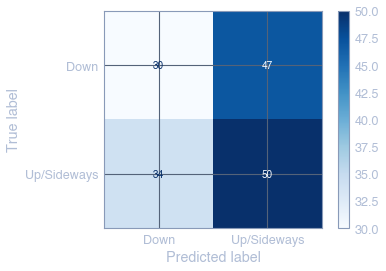

In [114]:
plot_confusion_matrix(rs, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Down', 'Up/Sideways']);

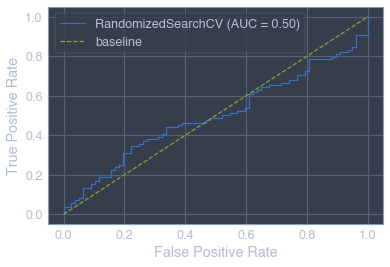

In [115]:
plot_roc_curve(rs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

# SVM Pipes

In [116]:
pipe4 = Pipeline([
    ('ss', StandardScaler()),
    ('SVC', SVC(probability=True,random_state=42))
    ])

params4 = {
          'SVC__gamma': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
          'SVC__C' : [1e-5, 1e-3, 1e-2, 1e-1, 0.1, 1],
          'SVC__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'SVC__class_weight' : ['balanced', None],
          'SVC__shrinking' : [True, False]
          }

cv_folds4 = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

gs4 = GridSearchCV(pipe4, params4, cv=cv_folds4, scoring='accuracy')

# Fit
gs4.fit(X_train, y_train)

preds = gs4.predict(X_test)

pred_proba = gs4.predict_proba(X_test)[:,1]

In [117]:
#Base Line
y_test.value_counts(normalize=True)

1.0    0.521739
0.0    0.478261
Name: Target_1d, dtype: float64

In [119]:
gs4.best_score_

0.5510610271553471

In [120]:
gs4.score(X_train,y_train) , gs4.score(X_test,y_test)

(0.9253567508232712, 0.5527950310559007)

In [121]:
metrics(y_test, preds, pred_proba)

Accuracy score 0.5527950310559007  

----------------------------------------------------------------
                   Actual Down  Actual Up/Unch
Predicted Down              26              51
Predicted Up/Unch           21              63 

-----------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.55      0.34      0.42        77
         1.0       0.55      0.75      0.64        84

    accuracy                           0.55       161
   macro avg       0.55      0.54      0.53       161
weighted avg       0.55      0.55      0.53       161

-----------------------------------------------------------------
ROC_AUC SCORE 0.54143475572047 


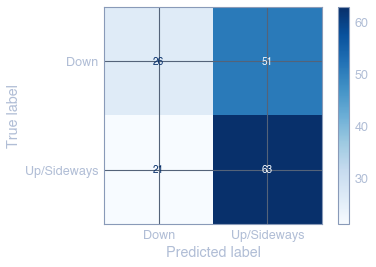

In [122]:
plot_confusion_matrix(gs4, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Down', 'Up/Sideways']);

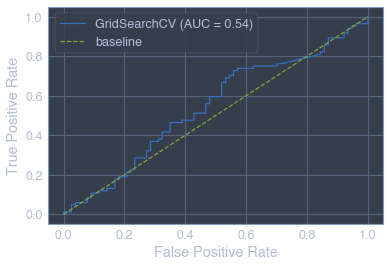

In [123]:
plot_roc_curve(gs4, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

# Neural Networks

In [177]:
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.layers import Dense, Input, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

# Baseline NN Model

In [151]:
# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(189, input_dim=189, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [154]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 50.71% (2.28%)


In [161]:
X_train.shape

(911, 189)

In [414]:
#Fit model on training data.
history = nn.fit(X_train,
                    y_train, 
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    verbose=1)

# always want to see steady decrease in loss, and steady increase in accuracy

Epoch 1/10
16/16 [==============================] - 0s 8ms/step - loss: 1245397632.0000 - accuracy: 0.4973 - val_loss: 69890056.0000 - val_accuracy: 0.4907
Epoch 2/10
16/16 [==============================] - 0s 2ms/step - loss: 417559232.0000 - accuracy: 0.5093 - val_loss: 31568228.0000 - val_accuracy: 0.5155
Epoch 3/10
16/16 [==============================] - 0s 2ms/step - loss: 264710192.0000 - accuracy: 0.4918 - val_loss: 45249932.0000 - val_accuracy: 0.5155
Epoch 4/10
16/16 [==============================] - 0s 2ms/step - loss: 182536144.0000 - accuracy: 0.4742 - val_loss: 9794134.0000 - val_accuracy: 0.5217
Epoch 5/10
16/16 [==============================] - 0s 2ms/step - loss: 124197488.0000 - accuracy: 0.5203 - val_loss: 10750422.0000 - val_accuracy: 0.4969
Epoch 6/10
16/16 [==============================] - 0s 2ms/step - loss: 90294320.0000 - accuracy: 0.5104 - val_loss: 12382460.0000 - val_accuracy: 0.4969
Epoch 7/10
16/16 [==============================] - 0s 2ms/step - loss:

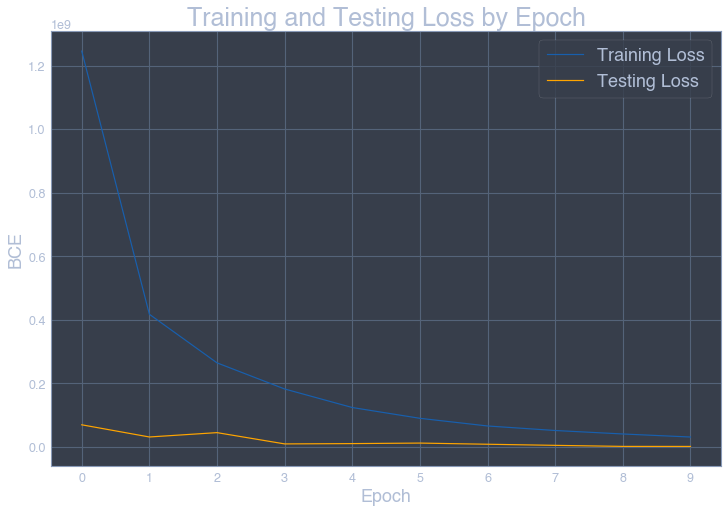

In [415]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('BCE', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [403]:
# Evaluate model on test data.
score = nn.evaluate(X_test,
                       y_test,
                       verbose=1)

labels = nn.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

6/6 [==============================] - 0s 512us/step - loss: 3947593.5000 - accuracy: 0.5217
loss: 3947593.5
accuracy: 0.52173912525177


In [404]:
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.49615806341171265, 0.52173912525177)

In [353]:
# Predicting the Test set results
y_pred = nn.predict(X_test)

pred_proba = nn.predict_proba(X_test)

accuracy of NN model is :  0.5341614906832298


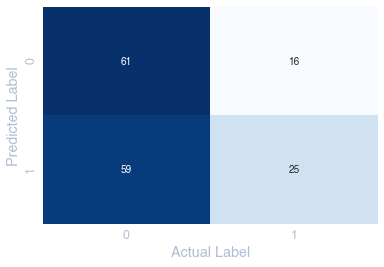

In [354]:
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)
#accuracy score
from sklearn.metrics import accuracy_score
ac=accuracy_score(y_test, y_pred.round())
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
print('accuracy of NN model is : ',ac)

In [355]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

<Figure size 432x288 with 0 Axes>

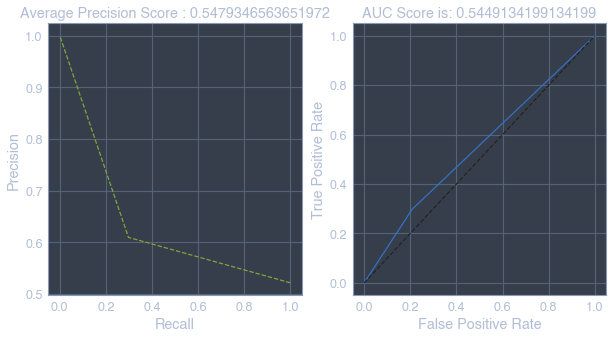

<Figure size 432x288 with 0 Axes>

In [356]:
def plotting(true,pred):
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    precision,recall,threshold = precision_recall_curve(true,pred)
    ax[0].plot(recall,precision,'g--')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title("Average Precision Score : {}".format(average_precision_score(true,pred)))
    fpr,tpr,threshold = roc_curve(true,pred)
    ax[1].plot(fpr,tpr)
    ax[1].set_title("AUC Score is: {}".format(auc(fpr,tpr)))
    ax[1].plot([0,1],[0,1],'k--')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
plotting(y_test,nn.predict_proba(X_test))
plt.figure()   

In [357]:
precision_score(y_test,preds)

0.5526315789473685

In [358]:
metrics(y_test, y_pred, pred_proba)

Accuracy score 0.5341614906832298  

----------------------------------------------------------------
                   Actual Down  Actual Up/Unch
Predicted Down              61              16
Predicted Up/Unch           59              25 

-----------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.51      0.79      0.62        77
         1.0       0.61      0.30      0.40        84

    accuracy                           0.53       161
   macro avg       0.56      0.54      0.51       161
weighted avg       0.56      0.53      0.50       161

-----------------------------------------------------------------
ROC_AUC SCORE 0.5449134199134199 


7/7 [==============================] - 0s 545us/step - loss: 143087808.0000 - accuracy: 0.6000
Model changed
7/7 [==============================] - 0s 498us/step - loss: 438106624.0000 - accuracy: 0.4813


In [253]:
# Compile the Train and Test Accuracy from KFold
pd.DataFrame({
    'Train Accuracy': tracc_arr,
    'Test Accuracy': acc_arr},
    index=range(1,6))

,Train Accuracy,Test Accuracy
1,0.498250,0.600000
2,0.525088,0.506977
3,0.532634,0.476636
4,0.518648,0.537383
5,0.531469,0.481308
